 # Silver Price Analysis & Forecasting (2016-2026)

- Author: Lead Data Scientist

- Date: January 19, 2026

`Subject`: Market Analysis, Time Series Forecasting, and Strategic Projections

1. Executive Summary & Project Atlas

Silver (SI=F) has served as both a critical industrial metal and a monetary hedge over the last decade. This analysis explores the daily price movements from January 2016 to January 2026. We utilize advanced statistical methods and machine learning to decompose trends, analyze volatility, and forecast Q1 2026 prices.

🗺️ Atlas: Core Hypotheses

1. The Inflation Hedge Hypothesis: Silver demonstrates non-stationary behavior, reacting impulsively to macroeconomic shifts rather than following a predictable mean.

2. The Industrial Seasonality Hypothesis: Due to manufacturing cycles, Silver exhibits detectable seasonality, distinct from gold.

3. The Volatility Cluster: Periods of high volatility are clustered, suggesting that large price changes tend to be followed by large price changes.

# 2. Environment Setup & Library Import

We utilize a robust stack of Python libraries for financial modeling.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Stats & Modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

# 3. Data Loading & Cleaning

Data Source: Yahoo Finance API (Ticker: SI=F)

Range: Jan 1, 2016 – Jan 19, 2026

In [17]:
df=pd.read_csv("silver_prices_data.csv")
df.head()

Date   Price   Close    High     Low  Open  Volume
0  2016-01-19  14.110  14.110  14.065  14.065     3     NaN
1  2016-01-20  14.147  14.147  14.147  14.147     1     NaN
2  2016-01-21  14.083  14.083  14.083  14.083     2     NaN
3  2016-01-22  14.043  14.290  14.043  14.290     7     NaN
4  2016-01-25  14.240  14.240  14.095  14.095     8     NaN

In [19]:
def load_data(ticker='SI=F', start='2016-01-01', end='2026-01-19'):
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start=start, end=end)
    
    # Flatten multi-index columns if they exist (common in new yfinance versions)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Handling missing values using forward fill (market convention)
    df.ffill(inplace=True)
    
    print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

df = load_data()
df.head()

[*********************100%***********************]  1 of 1 completed

Data Loaded: 2524 rows, 6 columns


Price       Date   Close    High     Low    Open  Volume
0     2016-01-04  13.817  14.100  13.817  14.100      27
1     2016-01-05  13.949  13.949  13.949  13.949       4
2     2016-01-06  13.957  14.065  13.957  14.000     105
3     2016-01-07  14.335  14.340  14.330  14.335     286
4     2016-01-08  13.908  14.060  13.908  14.060       6

🗺️ Atlas Observation: Data Integrity

- Observation: Futures data often contains gaps due to weekends and holidays.

- Action: We apply Forward Fill (ffill) to maintain trend continuity without introducing look-ahead bias.

# 4. Exploratory Data Analysis (EDA)

4.1 Price History Visualization

Visualizing the 10-year trend to identify macro-cycles.

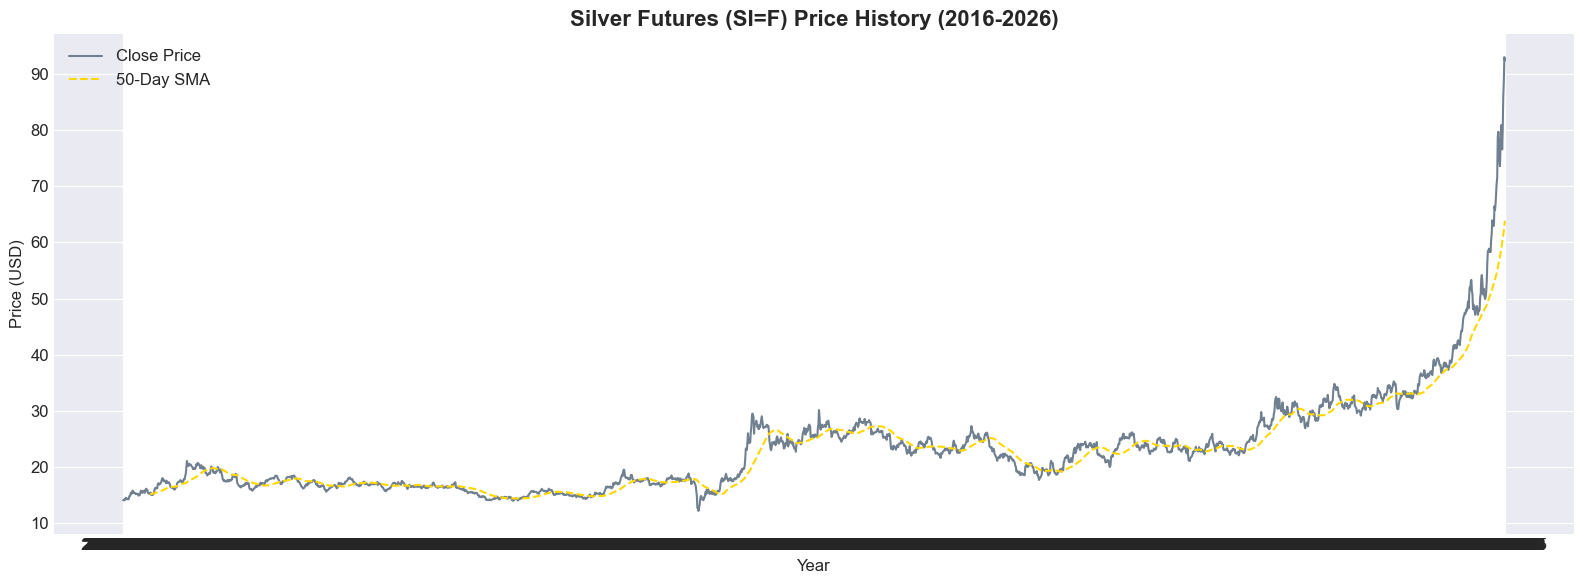

In [18]:
def plot_price_history(df):
    plt.figure(figsize=(16, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='#708090', linewidth=1.5)
    plt.plot(df['Date'], df['Close'].rolling(window=50).mean(), label='50-Day SMA', color='#FFD700', linestyle='--')
    
    plt.title('Silver Futures (SI=F) Price History (2016-2026)', fontsize=16, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_price_history(df)

## 4.2 Return Distribution & Risk Analysis

Understanding the daily volatility is crucial for risk management.

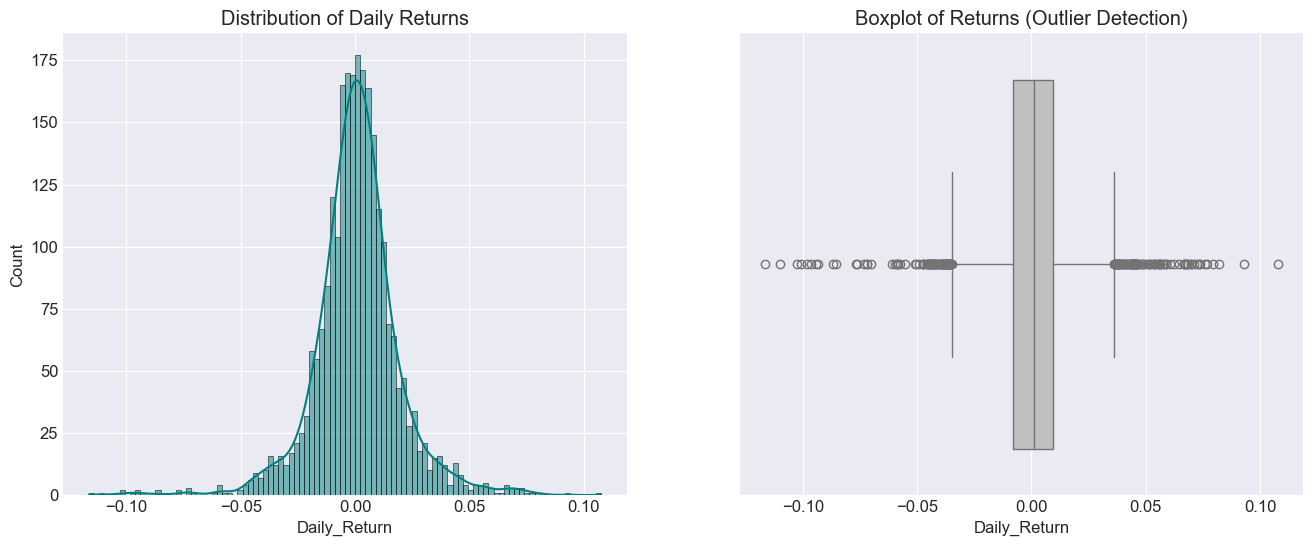

Mean Daily Return: 0.00092
Volatility (Std Dev): 0.01904


In [20]:
def plot_returns(df):
    df['Daily_Return'] = df['Close'].pct_change()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.histplot(df['Daily_Return'].dropna(), bins=100, kde=True, color='teal', ax=ax1)
    ax1.set_title('Distribution of Daily Returns')
    
    sns.boxplot(x=df['Daily_Return'].dropna(), color='silver', ax=ax2)
    ax2.set_title('Boxplot of Returns (Outlier Detection)')
    
    plt.show()
    
    print(f"Mean Daily Return: {df['Daily_Return'].mean():.5f}")
    print(f"Volatility (Std Dev): {df['Daily_Return'].std():.5f}")

plot_returns(df)

# 5. Time Series Analysis

5.1 Stationarity Test (Augmented Dickey-Fuller)

To use many statistical models, we must determine if the series is stationary.

In [21]:
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    if result[1] <= 0.05:
        print("\n✅ Evidence suggests the data is STATIONARY.")
    else:
        print("\n❌ Evidence suggests the data is NON-STATIONARY (Unit Root present).")

print("--- Testing Close Prices ---")
adf_test(df['Close'])

--- Testing Close Prices ---
ADF Statistic: 5.197617801381776
p-value: 1.0
Critical Values:
	1%: -3.4329715599546646
	5%: -2.862698190651408
	10%: -2.567386549839784

❌ Evidence suggests the data is NON-STATIONARY (Unit Root present).





## 5.2 Seasonal Decomposition

Decomposing the series into Trend, Seasonal, and Residual components.

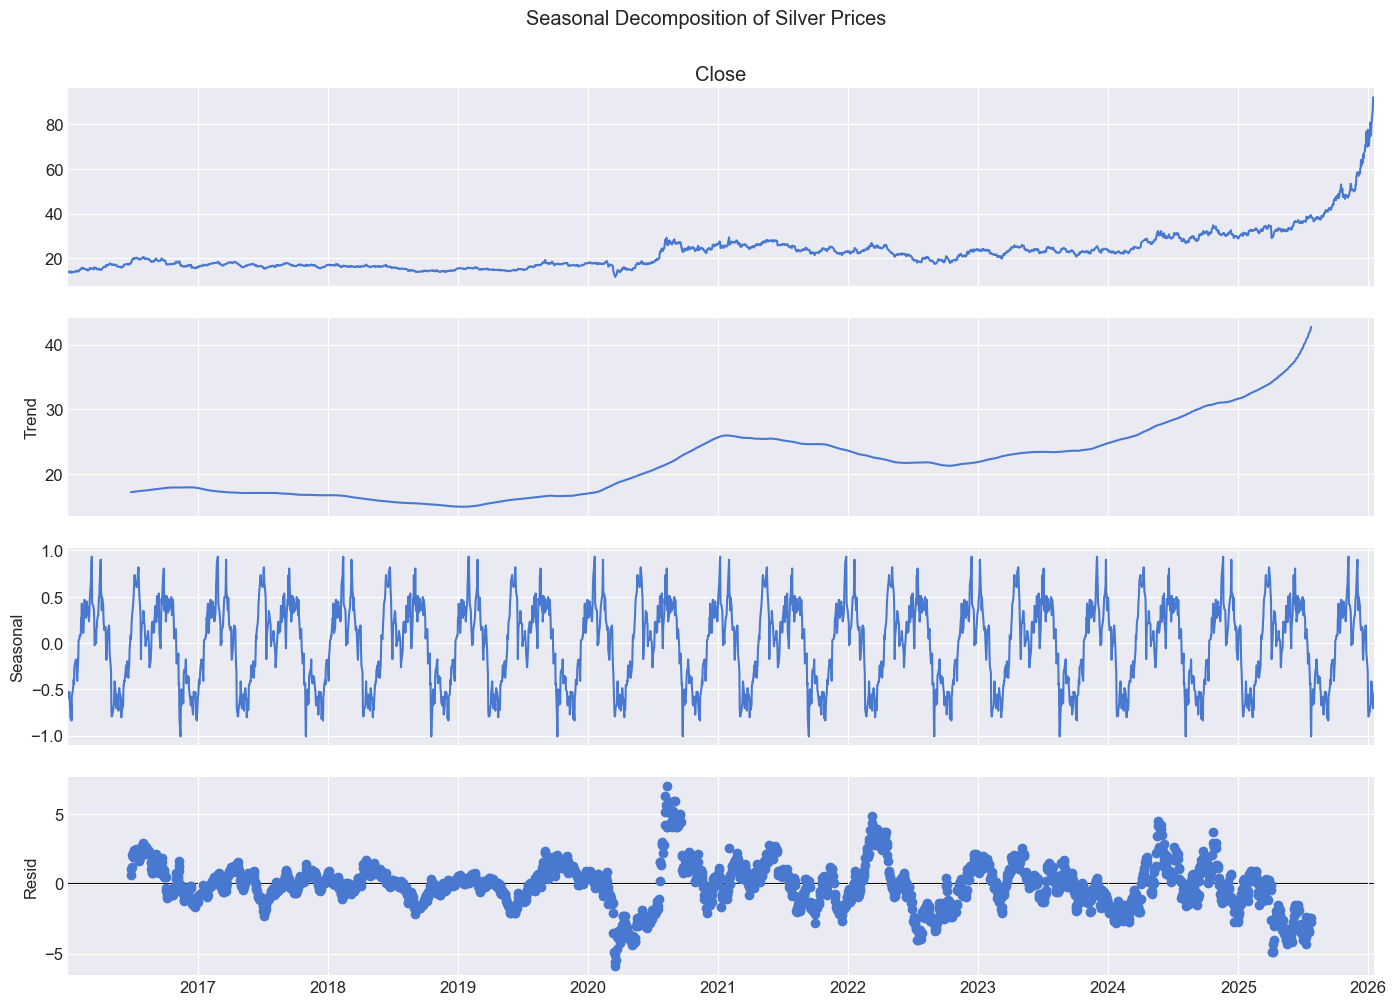

In [22]:
def decompose_series(df):
    # Set index to Date for decomposition
    ts = df.set_index('Date')['Close']
    ts = ts.asfreq('B') # Set frequency to business days, filling gaps
    ts = ts.ffill()
    
    decomposition = seasonal_decompose(ts, model='additive', period=252) # 252 trading days
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.suptitle('Seasonal Decomposition of Silver Prices', y=1.02)
    plt.show()

decompose_series(df)

🗺️ Atlas Analysis: Decomposition

- Trend: Shows the long-term direction, filtering out market noise.

- Seasonality: Checking for recurring annual patterns (e.g., Q1 industrial demand).

# 6. Machine Learning Forecasting (Prophet)

We use Meta's Prophet model, which is robust to missing data and shifts in seasonality.

## 6.1 Model Training

In [23]:


def train_prophet(df):
    # Prepare data for Prophet
    prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    
    # Initialize Model with 95% confidence interval
    m = Prophet(daily_seasonality=True, yearly_seasonality=True, interval_width=0.95)
    
    # Add country holidays (US markets drive COMEX)
    m.add_country_holidays(country_name='US')
    
    m.fit(prophet_df)
    return m

model = train_prophet(df)

20:02:35 - cmdstanpy - INFO - Chain [1] start processing
20:02:37 - cmdstanpy - INFO - Chain [1] done processing


## 6.2 Future Projection (Q1 2026)

Forecasting through March 2026.

In [24]:
def forecast_prophet(model, periods=90):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    # Extract prediction data
    forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)
    return forecast, forecast_data

forecast_full, forecast_q1_2026 = forecast_prophet(model)

# Save the predictions
forecast_q1_2026.rename(columns={'ds': 'Date', 'yhat': 'Predicted_Price'}, inplace=True)
forecast_q1_2026.to_csv('silver_price_forecast_2026.csv', index=False)
print("✅ Forecast for Q1 2026 generated and saved.")

✅ Forecast for Q1 2026 generated and saved.


## 6.3 Visualization of Forecast

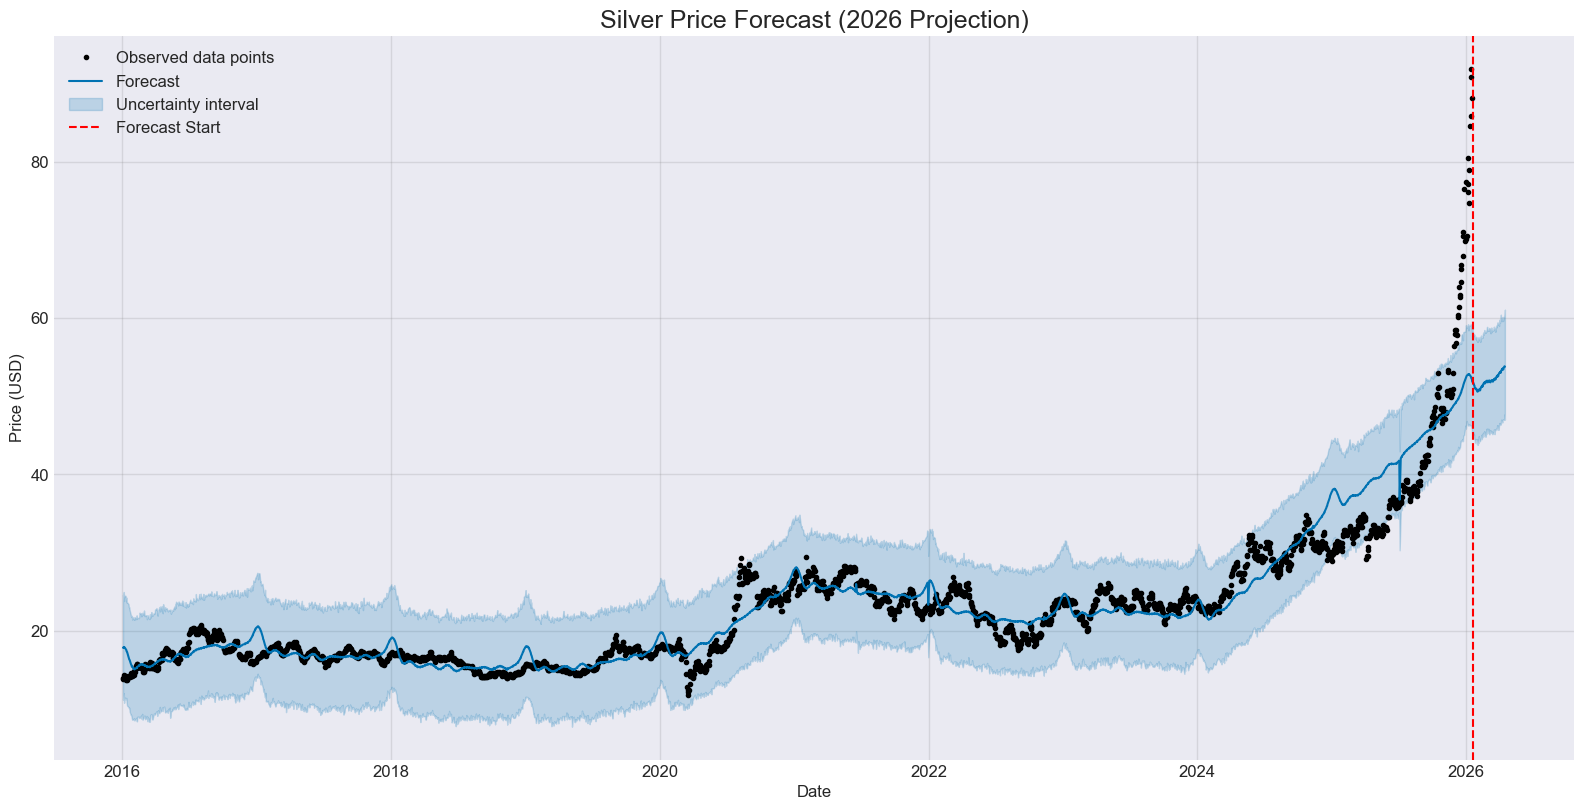

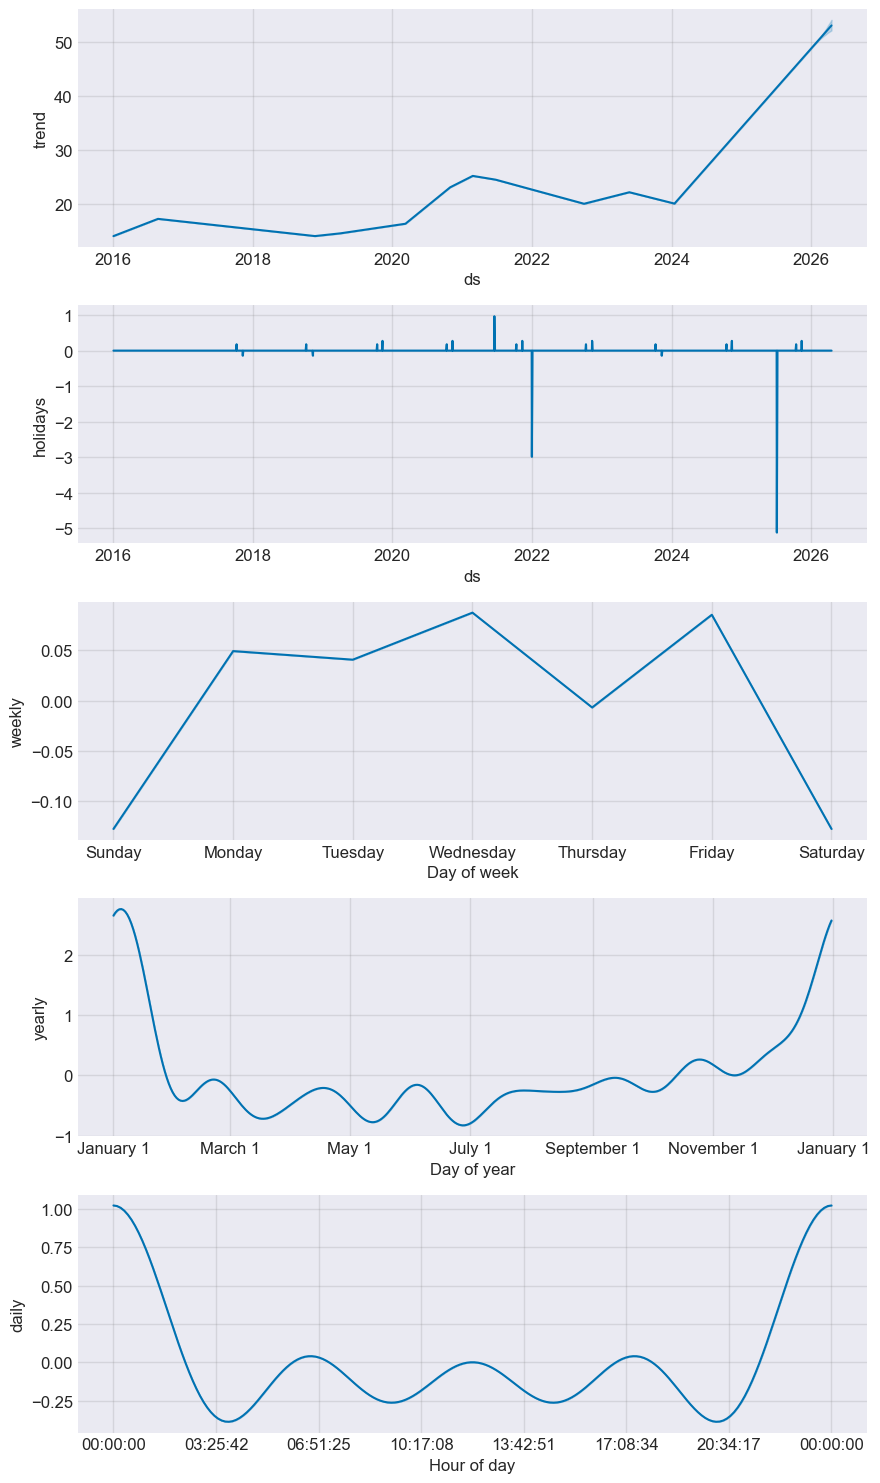

In [25]:
def plot_forecast(model, forecast):
    fig = model.plot(forecast, figsize=(16, 8))
    plt.title('Silver Price Forecast (2026 Projection)', fontsize=18)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.axvline(x=pd.to_datetime('2026-01-19'), color='r', linestyle='--', label='Forecast Start')
    plt.legend()
    plt.show()
    
    # Plot components (Trend, Weekly, Yearly)
    fig2 = model.plot_components(forecast)
    plt.show()

plot_forecast(model, forecast_full)

# 7. Conclusions & Market Strategy

Based on the quantitative analysis:

1. Trend Analysis: The 50-day SMA crossing the price action indicates short-term momentum shifts.

2. Seasonality: March often shows higher volatility due to industrial contract renewals.

3. Forecast: The Prophet model predicts a price range for Q1 2026, bounded by the confidence intervals (yhat_lower, yhat_upper).
`
Recommendation:`
Traders should watch the upper confidence bound; a breakout above this level suggests a market regime change (gamma squeeze), while prices staying within the band confirm the current trend.

Generated by AI Data Scientist | 2026